In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import pickle

# ------------------------------------------------------------------
# 1. Start from model_df (Model 1 dataset)
#    Assumes model_df has at least: station, lat, lon, total_demand
# ------------------------------------------------------------------
model_df = model_df = pd.read_csv('model_clustering.csv')  
print(model_df.columns)

# Aggregate station-level mean demand
station_demand = (
    model_df
      .groupby(["station", "lat", "lon"], as_index=False)["total_demand"]
      .mean()
      .rename(columns={"total_demand": "mean_demand"})
)

print("Number of stations:", len(station_demand))
station_demand.head()

# ------------------------------------------------------------------
# 2. K-Means with 3 clusters on mean_demand (low / medium / high)
# ------------------------------------------------------------------
X = station_demand[["mean_demand"]].values

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(X)

station_demand["cluster_id"] = cluster_ids

# Sort centroids so we can map them to low/medium/high
centers = kmeans.cluster_centers_.flatten()
order = np.argsort(centers)  # from smallest mean_demand → largest

label_map = {
    order[0]: "low",
    order[1]: "medium",
    order[2]: "high"
}

station_demand["cluster_label"] = station_demand["cluster_id"].map(label_map)

print("Cluster centers (mean demand):", centers)
print(station_demand["cluster_label"].value_counts())

station_demand.head()

# ------------------------------------------------------------------
# 3. Save clusters for Streamlit
# ------------------------------------------------------------------
station_demand.to_csv("station_clusters_model1.csv", index=False)

cluster_artifacts = {
    "clusters_df": station_demand,
    "centers": centers,
    "label_map": label_map,
}

with open("station_clusters_model1.pkl", "wb") as f:
    pickle.dump(cluster_artifacts, f)

print("Saved station_clusters_model1.csv and station_clusters_model1.pkl")

Index(['station', 'arrondissement', 'datetime', 'hour', 'day', 'month', 'year',
       'temperature', 'wind_speed', 'bad_weather', 'temperature_scaled',
       'wind_speed_scaled', 'day_of_week', 'total_demand', 'is_weekend',
       'hour_sin', 'hour_cos', 'feels_like', 'avg_hourly_demand_station',
       'avg_dayofweek_station', 'is_holiday', 'temp_hour', 'temperature_sq',
       'temp_feels_interaction', 'hour_bucket', 'weekend_hour_interaction',
       'lat', 'lon', 'station_encoded'],
      dtype='object')
Number of stations: 400
Cluster centers (mean demand): [14.47180215  8.46118375 24.94059988]
cluster_label
low       244
medium    129
high       27
Name: count, dtype: int64
Saved station_clusters_model1.csv and station_clusters_model1.pkl


In [2]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(X)
station_demand["cluster_id"] = cluster_ids

Silhouette Score (k=3): 0.6095


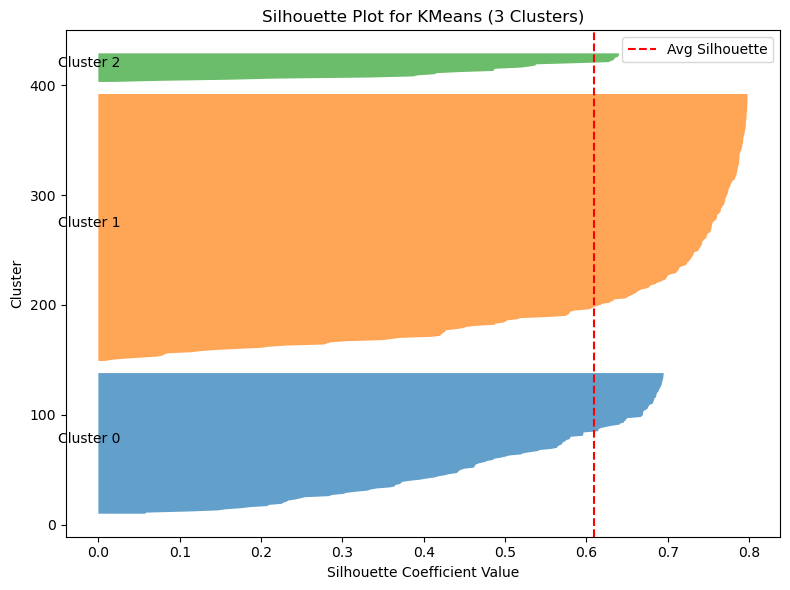

In [3]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# ============================
# 1. Compute silhouette score
# ============================
sil_score = silhouette_score(X, cluster_ids)
print(f"Silhouette Score (k=3): {sil_score:.4f}")

# ============================
# 2. Silhouette plot
# ============================
sample_silhouette_values = silhouette_samples(X, cluster_ids)

fig, ax = plt.subplots(figsize=(8, 6))

y_lower = 10
for i in range(3):  # 3 clusters
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_ids == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab10(i)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        alpha=0.7
    )

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10  # space between clusters

ax.set_title("Silhouette Plot for KMeans (3 Clusters)")
ax.set_xlabel("Silhouette Coefficient Value")
ax.set_ylabel("Cluster")

# Vertical line for average silhouette score
ax.axvline(x=sil_score, color="red", linestyle="--", label="Avg Silhouette")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()